<a href="https://colab.research.google.com/github/lucyford785/LELA60331_Classifier/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Pre-Processing and Splitting:

Import Data:

In [61]:
!wget https://anonymous.4open.science/r/LELA60331_Classifier-E86C/Edited_Reviews.txt

--2026-01-14 13:20:29--  https://anonymous.4open.science/r/LELA60331_Classifier-E86C/Edited_Reviews.txt
Resolving anonymous.4open.science (anonymous.4open.science)... 104.21.18.195, 172.67.183.76, 2606:4700:3037::6815:12c3, ...
Connecting to anonymous.4open.science (anonymous.4open.science)|104.21.18.195|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /api/repo/LELA60331_Classifier-E86C/file/Edited_Reviews.txt [following]
--2026-01-14 13:20:29--  https://anonymous.4open.science/api/repo/LELA60331_Classifier-E86C/file/Edited_Reviews.txt
Reusing existing connection to anonymous.4open.science:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘Edited_Reviews.txt.3’

Edited_Reviews.txt.     [              <=>   ]  21.29M  1.60MB/s    in 13s     

2026-01-14 13:20:43 (1.58 MB/s) - ‘Edited_Reviews.txt.3’ saved [22322566]



In [62]:
reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Edited_Reviews.txt") as f:
   for line in f.readlines()[1:]:
        fields = line.rstrip().split('\t')
        reviews.append(fields[0])
        sentiment_ratings.append(fields[1])
        product_types.append(fields[2])
        helpfulness_ratings.append(fields[3])

Determine number of helpful, unhelpful, and neutral reviews:

In [63]:
helpful=[i for i in helpfulness_ratings if i=='helpful']
unhelpful=[i for i in helpfulness_ratings if i=='unhelpful']
neutral=[i for i in helpfulness_ratings if i=='neutral']
print(len(helpful))
print(len(unhelpful))
print(len(neutral))

20350
5876
10321


Create random indices for a training, development, and test set:

In [65]:
import numpy as np
np.random.seed(12)
train_set=np.random.choice(len(reviews),int(len(reviews)*0.8),replace=False) #80% training
remaining=list(set(range(0,len(reviews))) - set(train_set))
dev_set=np.random.choice(len(remaining),int(len(remaining)*0.5),replace=False) #10% dev (half of remaining 20%)
test_set=list(set(range(0,len(remaining))) - set(dev_set)) #10% test (other half of remaining 20%)

Split reviews list:

In [66]:
reviews_train=[reviews[i] for i in train_set]
reviews_dev=[reviews[i] for i in dev_set]
reviews_test=[reviews[i] for i in test_set]

Split helpfulness ratings:

In [67]:
helpfulness_train=[helpfulness_ratings[i] for i in train_set]
helpfulness_dev=[helpfulness_ratings[i] for i in dev_set]
helpfulness_test=[helpfulness_ratings[i] for i in test_set]

One hot encode input data from reviews_train:

In [68]:
from collections import Counter
import re
r_train_tokens = [re.findall("[^ ]+",txt) for txt in reviews_train]
#Collapse all tokens into a single list
rt_tokens=[]
for token in r_train_tokens:
      rt_tokens.extend(token)
#Count tokens in the token list
counts=Counter(rt_tokens)
#Sort by most to least frequent
so=sorted(counts.items(), key=lambda item: item[1], reverse=True)
#Extract the list of tokens
so=list(zip(*so))[0]
#Select the first 200 words in the list - this is the vocabulary size
type_list=so[0:200]

In [69]:
#Create a matrix of zeros
x_train= np.zeros((len(reviews_train), len(type_list)))
#iterate over the reviews in training set
for i, review in enumerate(reviews_train):
    # Tokenise the current review:
    tokens = re.findall("[^ ]+",review)
    # iterate over the words in the vocabulary
    for j,t in enumerate(type_list):
        # if the current word j occurs in the current review i then set the matrix element at i,j to be one. Otherwise leave as zero.
        if t in tokens:
              x_train[i,j] = 1 #one hot encoded matrix - this is the input to the classifier

One hot encode y targets:

In [70]:
unique_h_train=list(set(helpfulness_train)) #select unique values in helpfulness ratings
h_train_onehot=np.diag(np.ones(len(unique_h_train))) #should be a 3x3 identity matrix
y_train=np.array([list(h_train_onehot[i]) for i in [unique_h_train.index(x) for x in helpfulness_train]]) #80% of set rows, 3 columns of one hot encoded helpfulness ratings

Train classifier:

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

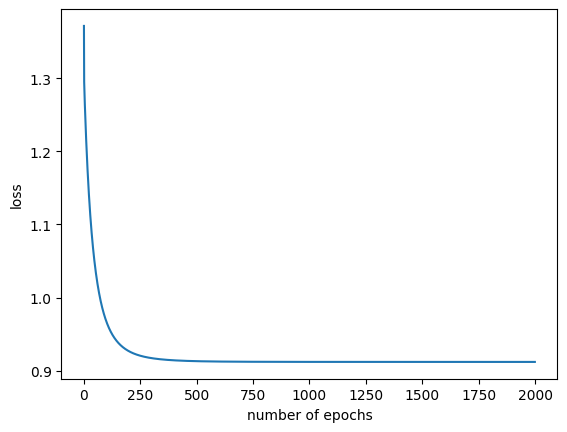

In [71]:
import matplotlib.pyplot as plt #visualise loss over iterations
from tqdm.auto import tqdm #progress bar
np.random.seed(12)
n_iters = 2000 #hyperparameter - can be altered
num_features=len(type_list) #vocabulary size
num_classes=3 #no. of helpfulness labels
num_samples=y_train.shape[0] #80% of dataset
weights = np.random.rand(num_classes,num_features).T
lr=0.5 #hyperparameter - can be altered
ce_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))

for i in tqdm(range(n_iters)):

    z=x_train.dot(weights)
    z_sum=np.exp(z).sum(axis=1)
    q=[(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)]

    loss=np.mean(-np.log((np.sum((y_train*q),axis=1))))

    ce_loss.append(loss)

    dw=x_train.T.dot((q-y_train))/num_samples
    weights=(weights - (dw*lr))

plt.plot(range(1,n_iters),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")


Inspect weights:


In [83]:
print(unique_h_train) #order of classes

['helpful', 'neutral', 'unhelpful']


In [89]:
print(y_train[9])

[1. 0. 0.]


In [90]:
print(weights[9]) #200 x 3 - each weight represents the usefulness of one vocab word for that particular class

[0.25878548 0.23780711 0.04558628]


Test classifier:

In order to obtain the exact values in the report, replace each 'test' variable with 'dev:

Keep the fixed vocabulary list created from training set and create one hot encoded x_test in the same way as x_train:

In [73]:
# Create a matrix of zeros
x_test= np.zeros((len(reviews_test), len(type_list)))
#iterate over the reviews
for i, review in enumerate(reviews_test):
    # Tokenise the current review:
    tokens = re.findall("[^ ]+",review)
    # iterate over the words in our type list (the set of 2500 words):
    for j,t in enumerate(type_list):
        # if the current word j occurs in the current review i then set the matrix element at i,j to be one. Otherwise leave as zero.
        if t in tokens:
              x_test[i,j] = 1

Same for y_test:

In [74]:
unique_h_test=list(set(helpfulness_test))
h_test_onehot=np.diag(np.ones(len(unique_h_test))) #should be a 3x3 identity matrix
y_test=np.array([list(h_test_onehot[i]) for i in [unique_h_test.index(x) for x in helpfulness_test]]) #80% of set rows, 3 columns of one hot encoded helpfulness ratings

In [76]:
z = x_test.dot(weights)
z_sum=np.exp(z).sum(axis=1)
q=[(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)]
y_test_pred=np.argmax(q,axis=1) #axis must be 1 since want 0 or 1 value
y_test_true=np.argmax(y_test,axis=1)

TP=[]
TN=[]
FP=[]
FN=[]
for j in range(3):#these output count of true positives, etc.
  TP.append(np.sum(np.array([int(s == j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))
  TN.append(np.sum(np.array([int(s !=j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))
  FP.append(np.sum(np.array([int(s == j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))
  FN.append(np.sum(np.array([int(s != j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))

In [80]:
print(FN)
print(np.sum(FN))

[np.int64(91), np.int64(962), np.int64(292)]
1345


In [81]:
print(FP)
print(np.sum(FP))

[np.int64(1215), np.int64(72), np.int64(58)]
1345


In [43]:
precision = (np.sum(TP))/(np.sum(TP)+np.sum(FP))
recall = np.sum(TP)/((np.sum(TP)+np.sum(FN)))
print("precision:",precision)
print("recall:", recall)

precision: 0.6320109439124487
recall: 0.6320109439124487


In [44]:
#macroaverage precision and recall:
#convert to np.arrays to avoid list concatenation
precision_by_class=np.array(TP)/(np.array(TP)+np.array(FP))
precision_macro=np.mean(precision_by_class)
print(precision_macro)

recall_by_class=np.array(TP)/(np.array(TP)+np.array(FN))
recall_macro=np.mean(recall_by_class)
print(recall_macro)

0.46953421311735943
0.3659527820181759


In [82]:
print(unique_h_test) #order of labels

['helpful', 'neutral', 'unhelpful']


In [79]:
print(precision_by_class, recall_by_class)

[0.64639115 0.47826087 0.28395062] [0.96064014 0.06420233 0.07301587]


#Batch training

Using 13 batches of size 2249






  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

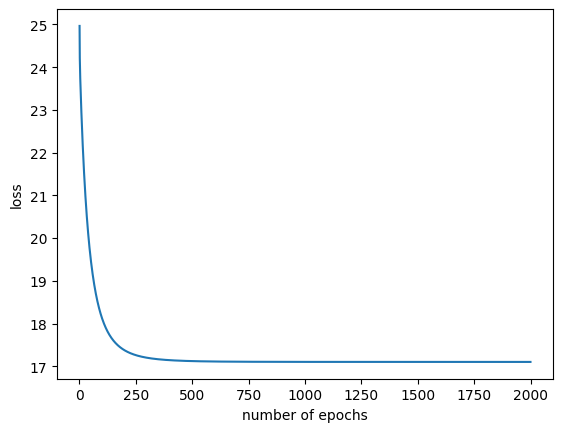

In [24]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
np.random.seed(12)
n_iters = 2000
num_features=len(type_list) #vocabulary size
num_classes=3 #no. of helpfulness labels
num_samples=y_train.shape[0] #80% of dataset
weights = np.random.rand(num_classes,num_features).T
lr=0.5
ce_loss=[]
z=np.zeros((num_samples,num_classes))
q=np.zeros((num_samples,num_classes))

import random
random.seed(12)
batch_size=2249
num_batches=13
batch_assignments=[0,1,2,3,4,5,6,7,8,9,10,11,12]*batch_size
random.shuffle(batch_assignments)

for i in tqdm(range(n_iters)):
  cumulative_loss=0.0

  for j in range(int(len(y_train)/batch_size)): #number of batches
    input = x_train[[ind for ind, v in enumerate(batch_assignments) if v == j]] #input value belongs to batch j
    targets = y_train[[ind for ind, v in enumerate(batch_assignments) if v == j]]
    z=input.dot(weights)
    z_sum=np.exp(z).sum(axis=1)
    q=[(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)]
    batch_loss=np.mean(-np.log2((np.sum((targets*q),axis=1))))
    cumulative_loss+=batch_loss

    dw=input.T.dot((q-targets))/num_samples
    weights=(weights - (dw*lr))

  ce_loss.append(cumulative_loss)  #loss output of this is per batch, so divide by batch size to obtain per sample and compare with instance by instance
plt.plot(range(1,n_iters),ce_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")

In [25]:
#cumulative loss
print(cumulative_loss)

17.103681728157724


In [26]:
#compute per sample loss:
print(cumulative_loss/num_batches)

1.315667825242902


In [30]:
z = x_test.dot(weights)
z_sum=np.exp(z).sum(axis=1)
q=[(np.exp(z_i)/z_sum[i]) for i, z_i in enumerate(z)]
y_test_pred=np.argmax(q,axis=1) #axis must be 1 since want 0 or 1 value
y_test_true=np.argmax(y_test,axis=1)

TP=[]
TN=[]
FP=[]
FN=[]
for j in range(3): #these output count of true positives, etc.
  TP.append(np.sum(np.array([int(s == j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))
  TN.append(np.sum(np.array([int(s !=j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))
  FP.append(np.sum(np.array([int(s == j and y_test_true[i] != j) for i,s in enumerate(y_test_pred)])))
  FN.append(np.sum(np.array([int(s != j and y_test_true[i] == j) for i,s in enumerate(y_test_pred)])))

In [31]:
precision = (np.sum(TP))/(np.sum(TP)+np.sum(FP))
recall = np.sum(TP)/((np.sum(TP)+np.sum(FN)))
print("precision:",precision)
print("recall:", recall)

precision: 0.6320109439124487
recall: 0.6320109439124487


In [32]:
precision_by_class=np.array(TP)/(np.array(TP)+np.array(FP))
precision_macro=np.mean(precision_by_class)
print(precision_macro)

recall_by_class=np.array(TP)/(np.array(TP)+np.array(FN))
recall_macro=np.mean(recall_by_class)
print(recall_macro)

0.47056995094191034
0.36577270312005683
